In [ ]:
!pip install transformers datasets nltk torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install datasets transformers nltk torch


In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load CNN/DailyMail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Reduce dataset size (10% of each split for faster training)
train_sampled = dataset["train"].shuffle(seed=42).select(range(int(0.1 * len(dataset["train"]))))
val_sampled = dataset["validation"].shuffle(seed=42).select(range(int(0.1 * len(dataset["validation"]))))
test_sampled = dataset["test"].shuffle(seed=42).select(range(int(0.1 * len(dataset["test"]))))

# Convert to DatasetDict
dataset_sampled = {
    "train": train_sampled,
    "validation": val_sampled,
    "test": test_sampled
}

print(f"Dataset size: Train - {len(train_sampled)}, Validation - {len(val_sampled)}, Test - {len(test_sampled)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset size: Train - 28711, Validation - 1336, Test - 1149


In [ ]:
# Load BART tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

# Tokenization function
def preprocess_function(batch):
    source_ids = tokenizer(batch["article"], truncation=True, padding="max_length", max_length=512)
    target_ids = tokenizer(batch["highlights"], truncation=True, padding="max_length", max_length=128)

    labels = [[(label if label != tokenizer.pad_token_id else -100) for label in example] for example in target_ids["input_ids"]]

    return {
        "input_ids": source_ids["input_ids"],
        "attention_mask": source_ids["attention_mask"],
        "labels": labels
    }

# Apply tokenization with batch size 8
batch_size = 8  # Reduce to 4 if memory issues occur
tokenized_datasets = {split: dataset_sampled[split].map(preprocess_function, batched=True, batch_size=batch_size) for split in ["train", "validation", "test"]}

print("Tokenization complete! Dataset is ready for training.")


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/28711 [00:00<?, ? examples/s]

Map:   0%|          | 0/1336 [00:00<?, ? examples/s]

Map:   0%|          | 0/1149 [00:00<?, ? examples/s]

Tokenization complete! Dataset is ready for training.


In [ ]:
# Load the BART model for summarization
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. Access Dataset Features (metadata)
print("Dataset Features:")
print(dataset_sampled["train"].features)


Dataset Features:
{'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


In [ ]:

# 2. Head and Tail - Display first and last few records from the dataset
print("First few rows of the dataset (Sample):")
print(dataset_sampled["train"][:3])  # Display first 3 rows

First few rows of the dataset (Sample):
{'article': ["By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of the same family who were found in their static caravan last weekend. John and Audrey Cook are pictured . Awful: The family died following carbon monoxide poisoning at this caravan at the Tremarle Home Park in Camborne, Cornwall . It is also believed th

In [ ]:
# Convert to Pandas DataFrame to easily display last rows
train_df = dataset_sampled["train"].to_pandas()
print("Last few rows of the dataset (Sample):")
print(train_df.tail(3))  # Display last 3 rows


Last few rows of the dataset (Sample):
                                                 article  \
28708  By . Lucy Waterlow . PUBLISHED: . 14:36 EST, 2...   
28709  (CNN) -- A key suspect in the 2008 Mumbai terr...   
28710  London (CNN) -- The extradition of honeymoon k...   

                                              highlights  \
28708  Cara was born into a privileged British high s...   
28709  The suspect is identified as Abu Jundal .\nInv...   
28710  He cannot be sent to South Africa on mental he...   

                                             id  
28708  4a896c5a7ebf52bf9ce3e16d76cc12571811726e  
28709  af16bac2feb62ed580f3331de6d7c84dfc20d45c  
28710  25320dc47859a7e28f35abd77aba97f1a8f2e10f  


In [ ]:
# 3. Null Values Check - Checking if there are any missing values in the dataset
print("Null values in dataset:")
print(train_df.isnull().sum())  # Will print null counts for each column

Null values in dataset:
article       0
highlights    0
id            0
dtype: int64


In [ ]:
# 4. Descriptive statistics - For numerical columns (if any)
print("Descriptive statistics:")
print(train_df.describe())

Descriptive statistics:
                                                  article  \
count                                               28711   
unique                                              28678   
top     BEIJING, China (CNN) -- The head of China's qu...   
freq                                                    2   

                                               highlights  \
count                                               28711   
unique                                              28630   
top     The daily transcript is a written version of e...   
freq                                                   10   

                                              id  
count                                      28711  
unique                                     28711  
top     25320dc47859a7e28f35abd77aba97f1a8f2e10f  
freq                                           1  


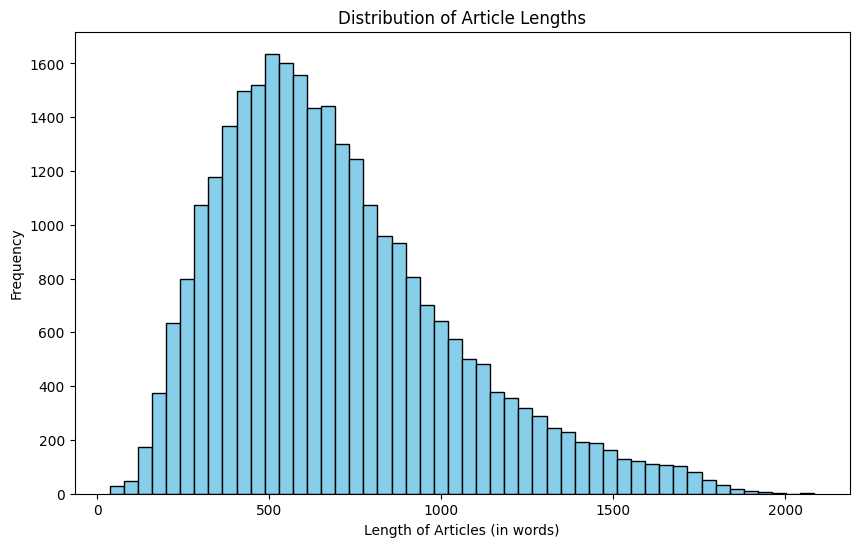

In [ ]:
# 5. Graphs - Distribution of Article Lengths
# Use a list comprehension instead of apply
article_lengths = [len(str(article).split()) for article in dataset_sampled['train']['article']]

plt.figure(figsize=(10, 6))
plt.hist(article_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Article Lengths')
plt.xlabel('Length of Articles (in words)')
plt.ylabel('Frequency')
plt.show()

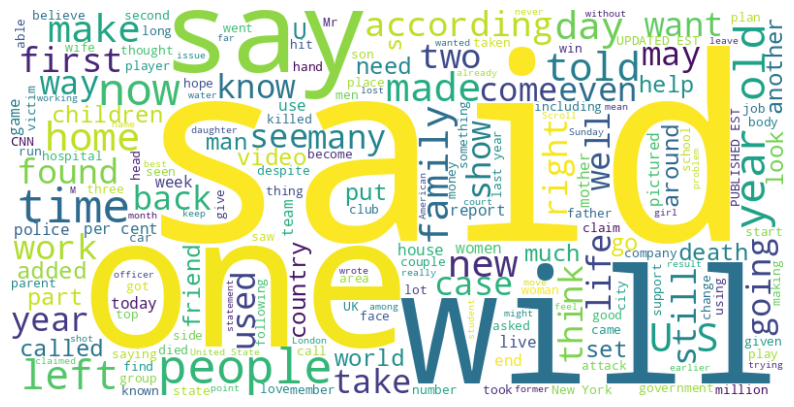

In [ ]:
# 6. Word Cloud for Articles - Generate a word cloud from the articles
text = " ".join(dataset_sampled['train']['article'])  # Concatenate all articles into one long string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datasets import Dataset

# Manually download necessary NLTK resources
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopword removal
nltk.download('wordnet')  # For lemmatization

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing Section - Tokenization, Stopword Removal, Lemmatization
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]  # Stopwords removal
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
training_args = Seq2SeqTrainingArguments(
    gradient_accumulation_steps=4,  # Simulate a larger batch size with smaller steps
)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",  # Evaluate after certain steps
    save_strategy="steps",
    eval_steps=1000,  # Evaluate every 1000 steps (to reduce evaluation frequency)
    save_steps=1000,  # Save every 1000 steps to avoid losing progress
    per_device_train_batch_size=4,  # Start with batch size of 4 for free Colab
    per_device_eval_batch_size=4,  # Evaluate with batch size of 4
    learning_rate=3e-5,  # Fine-tune learning rate for better convergence
    weight_decay=0.01,
    save_total_limit=3,  # Limit number of saved models to 3
    num_train_epochs=5,  # More epochs for better performance
    predict_with_generate=True,
    fp16=True,  # Use mixed precision if GPU is available
    logging_dir="./logs",
    logging_steps=500,  # Log training progress every 500 steps
    gradient_accumulation_steps=4,  # Simulate larger batch size with gradient accumulation
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

print("Trainer setup complete!")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-776821415563>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Trainer setup complete!


In [ ]:
import wandb

# ... your existing code ...

# Before calling trainer.train(), initialize wandb:
wandb.init(project="my-summarization-project", name="bart-large-cnn")

trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vaidyaao (vaidyaao-shri-ramdeobaba-college-of-engineering-and-mana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
1000,1.445700,1.509572
2000,1.321900,1.556689
3000,1.177400,1.555383
4000,0.988700,1.639969
5000,0.964700,1.642829
6000,0.791900,1.737656
7000,0.806000,1.744663
8000,0.695100,1.835707


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=8970, training_loss=1.014467866657304, metrics={'train_runtime': 12252.7788, 'train_samples_per_second': 11.716, 'train_steps_per_second': 0.732, 'total_flos': 1.554724183647191e+17, 'train_loss': 1.014467866657304, 'epoch': 4.997492337698524})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 1.831851601600647, 'eval_runtime': 27.7673, 'eval_samples_per_second': 48.114, 'eval_steps_per_second': 12.029, 'epoch': 4.997492337698524}


In [ ]:
!pip install transformers datasets nltk rouge-score evaluate torch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=958008e1be5d9d24bf2e83f9bccea2874ec53bc2c35dfa15766abd069976a40a
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ✅ Create a folder path in your Google Drive
save_path = "/content/drive/MyDrive/bart_summarization_model"

# ✅ Save model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Model saved to:", save_path)

Model saved to: /content/drive/MyDrive/bart_summarization_model


In [ ]:
!pip install evaluate  # Run once to install

import evaluate  # Make sure this line is at the top

# ✅ Load evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# ✅ Define metric computation function
def compute_metrics(predictions, references):
    rouge_scores = rouge.compute(predictions=predictions, references=references)
    meteor_score = meteor.compute(predictions=predictions, references=references)
    return {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "METEOR": meteor_score["meteor"]
    }


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
model_path = "/content/drive/MyDrive/bart_summarization_model"  # your path

tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [ ]:
# Generate summaries using your model
inputs = tokenizer(article, return_tensors="pt", max_length=1024, truncation=True).to(model.device)
summary_ids = model.generate(
    **inputs,
    max_length=128,
    num_beams=4,
    no_repeat_ngram_size=3,
    early_stopping=True
)
generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:
!pip install evaluate  # Run this only once
import evaluate

# Load metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# Select 5 test examples
samples = dataset.select(range(5))

predictions = []
references = []

# Generate summaries
for sample in samples:
    article = sample["article"]
    reference = sample["highlights"]

    # Generate summary from your trained model
    inputs = tokenizer(article, return_tensors="pt", max_length=1024, truncation=True).to(model.device)
    summary_ids = model.generate(
        **inputs,
        max_length=128,
        num_beams=4,
        no_repeat_ngram_size=3,
        early_stopping=True
    )
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    predictions.append(generated_summary)
    references.append(reference)

# Compute scores
rouge_scores = rouge.compute(predictions=predictions, references=references)
meteor_score = meteor.compute(predictions=predictions, references=references)

# Print nicely
print("🔹 ROUGE Scores:")
for k, v in rouge_scores.items():
    print(f"{k}: {v:.4f}")

print("\n🔹 METEOR Score:")
print(f"METEOR: {meteor_score['meteor']:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


🔹 ROUGE Scores:
rouge1: 0.4404
rouge2: 0.2239
rougeL: 0.3249
rougeLsum: 0.4018

🔹 METEOR Score:
METEOR: 0.3653


In [ ]:
import evaluate
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

# ✅ Load model and tokenizer from your trained path
model_path = "/content/drive/MyDrive/bart_summarization_model"  # <-- update if needed
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path).to("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# ✅ Load test dataset (5 samples)
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:5]")

# ✅ Generate summaries + calculate scores
for i, sample in enumerate(dataset):
    article = sample["article"]
    reference = sample["highlights"]

    # Generate summary
    inputs = tokenizer(article, return_tensors="pt", max_length=1024, truncation=True).to(model.device)
    summary_ids = model.generate(
        **inputs,
        max_length=128,
        num_beams=4,
        no_repeat_ngram_size=3,
        early_stopping=True
    )
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Compute individual scores
    rouge_result = rouge.compute(predictions=[generated_summary], references=[reference])
    meteor_result = meteor.compute(predictions=[generated_summary], references=[reference])

    # Print everything
    print(f"\n{'='*80}")
    print(f"📰 ARTICLE #{i+1}\n")
    print(f"✅ Generated Summary:\n{generated_summary}\n")
    print(f"🧾 Reference Summary:\n{reference}\n")
    print(f"📊 Evaluation Scores:")
    print(f"🔹 ROUGE-1: {rouge_result['rouge1']:.4f}")
    print(f"🔹 ROUGE-2: {rouge_result['rouge2']:.4f}")
    print(f"🔹 ROUGE-L: {rouge_result['rougeL']:.4f}")
    print(f"🔹 METEOR:  {meteor_result['meteor']:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



📰 ARTICLE #1

✅ Generated Summary:
Israel and the United States opposed the Palestinians' efforts to join the court .
The ICC opened a preliminary examination into the situation in Palestinian territories in January .
It could pave the way for possible war crimes investigations against Israelis .

🧾 Reference Summary:
Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .

📊 Evaluation Scores:
🔹 ROUGE-1: 0.5479
🔹 ROUGE-2: 0.3662
🔹 ROUGE-L: 0.3836
🔹 METEOR:  0.5427

📰 ARTICLE #2

✅ Generated Summary:
Theia the dog was hit by a car, buried and apparently hit on the head with a hammer, then somehow survived .
She was found four days later, dirt-covered and emaciated, at a farm .
A fundraising campaign has raised more than $10,000 to help Theia and her medical bills .

🧾 Reference Summary:
Theia, a bully breed mi